In [1]:
import sys, os
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
%matplotlib notebook
plt.rcParams['figure.figsize'] = [10, 5]

spark = (
    SparkSession.builder.appName("PySpark Hive Session from Jupyter Notebook")
    .config(
        "spark.master",
        "spark://{}:{}".format("spark-master", "7077"),
    )
    .config(
        "spark.hadoop.hive.metastore.uris",
        "thrift://{}:{}".format("hive-metastore", "9083"),
    )
    .config("spark.sql.warehouse.dir", "/hive/warehouse/dir")
    .config("spark.executor.memory", "10g")
    .config("spark.executor.cores", "2")
#     .config("spark.cores.max", "2")
    .config("spark.executor.instances", "1")
    .config("spark.debug.maxToStringFields", "100")
    .enableHiveSupport()
    .getOrCreate()
)

23/10/25 12:37:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
bid_ask_real_per_minute_raw_df = spark.sql(
    """
        with avg_ask_quote_price_per_seqid as
        (
            select
                date_trunc('minute', ts_create_utc) as ts,
                seqid,
                avg(quote_price) as avg_quote_price,
                approx_percentile(quote_price, 0.5) as med_quote_price
            from 
                crypto_raw.order_book 
            where 
                id = 'BTC_USDT'
                and order_type = 'ask'
            group by
                ts_create_utc,
                seqid
        ),
        avg_bid_quote_price_per_seqid as
        (
            select
                date_trunc('minute', ts_create_utc) as ts,
                seqid,
                avg(quote_price) as avg_quote_price,
                approx_percentile(quote_price, 0.5) as med_quote_price
            from 
                crypto_raw.order_book 
            where 
                id = 'BTC_USDT'
                and order_type = 'bid'
            group by
                ts_create_utc,
                seqid
        ),
        close_price_per_minute as
        (
            select 
                date_trunc('minute', ts_create_utc) as ts,
                close as real_close_price
            from 
                crypto_raw.candles_minute
            where
                id = 'BTC_USDT'
                and ts_create_utc >= (select min(ts_create_utc) from crypto_raw.market_trade)
        )
        select
            bid.ts as ts,
            count(bid.avg_quote_price) as order_count,
            avg(bid.avg_quote_price) as bid_avg_quote_price,
            approx_percentile(bid.med_quote_price, 0.5) as bid_med_quote_price,
            avg(ask.avg_quote_price) as ask_avg_quote_price,
            approx_percentile(ask.med_quote_price, 0.5) as ask_med_quote_price,
            avg(_close.real_close_price) as real_close_price
        from 
            avg_bid_quote_price_per_seqid as bid
        left join 
            avg_ask_quote_price_per_seqid as ask
        on
            bid.ts = ask.ts
            and bid.seqid = ask.seqid
        left join
            close_price_per_minute as _close
        on
            bid.ts = _close.ts
        group by 
            1
        order by 
            1
    """
)


23/10/25 12:38:05 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.


<IPython.core.display.Javascript object>


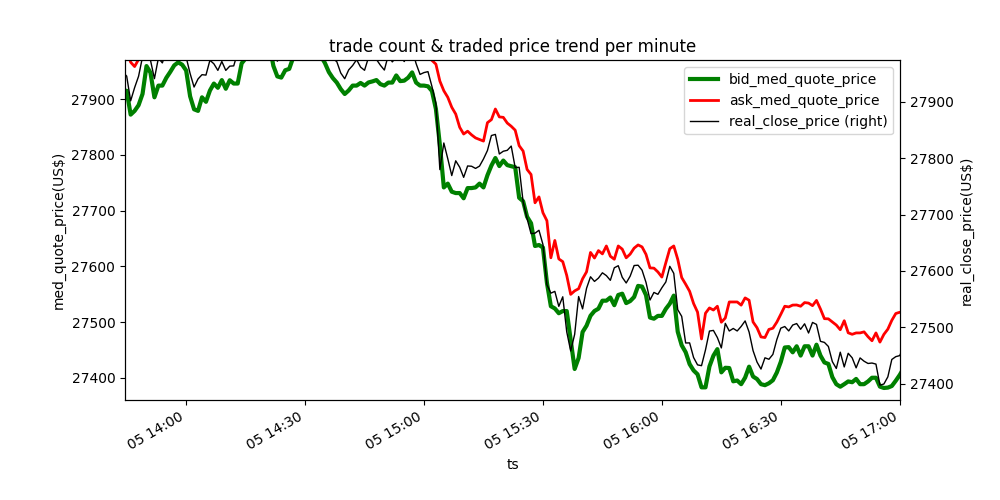

Text(0, 0.5, 'real_close_price(US$)')

In [4]:
bid_ask_real_per_minute_df = bid_ask_real_per_minute_raw_df \
    .orderBy(['ts']) \
    .where(bid_ask_real_per_minute_raw_df['ts'] >= '2023-10-01') \
    .toPandas()


# creating axes object and defining plot
ax = order_by_second[["ts","bid_med_quote_price"]] \
    .plot(kind = 'line', x = 'ts', \
         y = 'bid_med_quote_price', \
         color = 'Green', linewidth = 3)

ax2 = order_by_second[["ts","ask_med_quote_price"]] \
    .plot(kind = 'line', x = 'ts', \
         y = 'ask_med_quote_price', \
         color = 'Red', linewidth = 2, ax = ax)

ax3 = order_by_second[["ts","real_close_price"]] \
    .plot(kind = 'line', x = 'ts', \
          y = 'real_close_price', secondary_y = True, \
          color = 'black',  linewidth = 1, ax = ax)
 
plt.title("Ask, Bid, and Close price every minute")
 

ax.set_xlabel('ts', color = 'black')
ax.set_ylabel('med_quote_price(US$)', color = "black")
ax3.set_ylabel('real_close_price(US$)', color = 'black')

In [5]:
bid_ask_real_per_second_raw_df = spark.sql(
    """
        with avg_ask_quote_price_per_seqid as
        (
            select
                date_trunc('second', ts_create_utc) as ts,
                seqid,
                avg(quote_price) as avg_quote_price,
                approx_percentile(quote_price, 0.5) as med_quote_price
            from 
                crypto_raw.order_book 
            where 
                id = 'BTC_USDT'
                and order_type = 'ask'
            group by
                ts_create_utc,
                seqid
        ),
        avg_bid_quote_price_per_seqid as
        (
            select
                date_trunc('second', ts_create_utc) as ts,
                seqid,
                avg(quote_price) as avg_quote_price,
                approx_percentile(quote_price, 0.5) as med_quote_price
            from 
                crypto_raw.order_book 
            where 
                id = 'BTC_USDT'
                and order_type = 'bid'
            group by
                ts_create_utc,
                seqid
        ),
        close_price_per_minute as
        (
            select 
                date_trunc('minute', ts_create_utc) as ts,
                close as real_close_price
            from 
                crypto_raw.candles_minute
            where
                id = 'BTC_USDT'
                and ts_create_utc >= (select min(ts_create_utc) from crypto_raw.market_trade)
        )
        select
            bid.ts,
            count(bid.avg_quote_price) as order_count,
            avg(bid.avg_quote_price) as bid_avg_quote_price,
            approx_percentile(bid.med_quote_price, 0.5) as bid_med_quote_price,
            avg(ask.avg_quote_price) as ask_avg_quote_price,
            approx_percentile(ask.med_quote_price, 0.5) as ask_med_quote_price,
            avg(_close.real_close_price) as real_close_price
        from 
            avg_bid_quote_price_per_seqid as bid
        left join 
            avg_ask_quote_price_per_seqid as ask
        on
            bid.ts = ask.ts
            and bid.seqid = ask.seqid
        left join
            close_price_per_minute as _close
        on
            bid.ts = _close.ts
        group by 
            1
        order by 
            1
    """
)

<IPython.core.display.Javascript object>


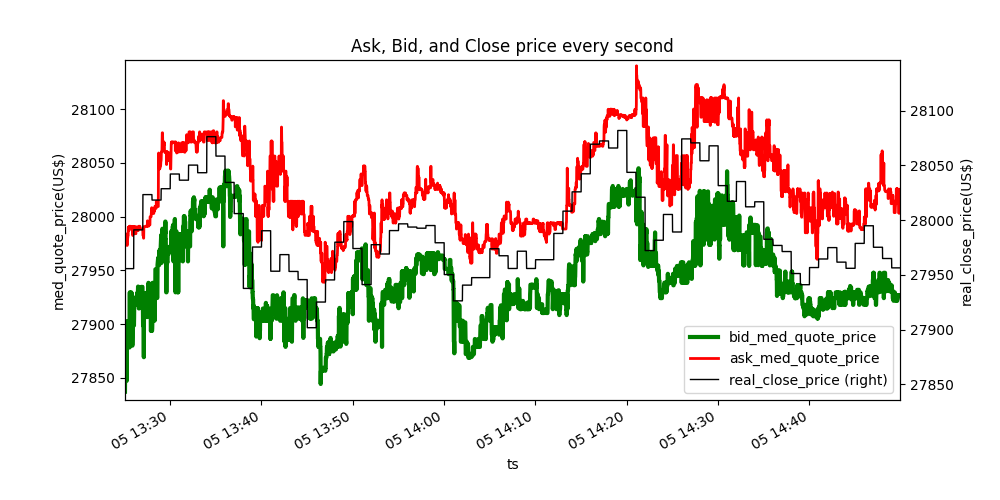

Text(0, 0.5, 'real_close_price(US$)')

In [14]:
bid_ask_real_per_second_df = bid_ask_real_per_second_raw_df \
    .orderBy(['ts']) \
    .where(bid_ask_real_per_second_raw_df['ts'] >= '2023-10-01') \
    .toPandas()

bid_ask_real_per_second_df['real_close_price'] = bid_ask_real_per_second_df['real_close_price'].fillna(method='bfill')
bid_ask_real_per_second_df['real_close_price'] = bid_ask_real_per_second_df['real_close_price'].fillna(method='ffill')


# creating axes object and defining plot
ax = bid_ask_real_per_second_df[["ts","bid_med_quote_price"]] \
    .plot(kind = 'line', x = 'ts', \
         y = 'bid_med_quote_price', \
         color = 'Green', linewidth = 3)

ax2 = bid_ask_real_per_second_df[["ts","ask_med_quote_price"]] \
    .plot(kind = 'line', x = 'ts', \
         y = 'ask_med_quote_price', \
         color = 'Red', linewidth = 2, ax = ax)

ax3 = bid_ask_real_per_second_df[["ts","real_close_price"]] \
    .plot(kind = 'line', x = 'ts', \
          y = 'real_close_price', secondary_y = True, \
          color = 'black',  linewidth = 1, ax = ax)
 
plt.title("Ask, Bid, and Close price every second")
 
ax.set_xlabel('ts', color = 'black')
ax.set_ylabel('med_quote_price(US$)', color = "black")
ax3.set_ylabel('real_close_price(US$)', color = 'black')

In [ ]:
# Read the data from Hive table
crypto_raw_order_book = spark.table("crypto_raw.order_book")

# Apply the filter conditions
filtered_data = crypto_raw_order_book.filter((crypto_raw_order_book["id"] == "BTC_USDT") &
                                             (crypto_raw_order_book["order_type"] == "ask") &
                                             (crypto_raw_order_book["dt_create_utc"] >= "2023-10-01"))

# Define aggregation and select columns
result = filtered_data.groupBy("ts_create_utc", "seqid").agg(
    avg("quote_price").alias("avg_quote_price"),
    percentile_approx("quote_price", 0.5).alias("med_quote_price")
)

# Order the result by columns 1 (ts_create_utc) and 2 (seqid)
result = result.orderBy("ts_create_utc", "seqid")

# result_df = result.toPandas()

In [ ]:
result.summary().show()

In [ ]:
result_df.tail()

In [ ]:
result_df.describe()

In [ ]:
# creating axes object and defining plot
ax = result_df[["seqid","avg_quote_price"]] \
    .plot(kind = 'line', x = 'seqid', \
         y = 'avg_quote_price', \
         color = 'Green', linewidth = 1)

ax2 = result_df[["seqid","med_quote_price"]] \
    .plot(kind = 'line', x = 'seqid', \
         y = 'med_quote_price', \
         color = 'Red', linewidth = 1, ax = ax)
    
#title of the plot
plt.title("avg_quote_price_per_seqid")
 
#labeling x and y-axis
ax.set_xlabel('seqid', color = 'black')
ax.set_ylabel('Price(US$)', color = "black")


In [ ]:
# Apply the filter conditions and calculate average and median per seqid
avg_quote_price_per_seqid = \
    crypto_raw_order_book \
    .filter(
        (crypto_raw_order_book["id"] == "BTC_USDT") &
        (crypto_raw_order_book["order_type"] == "ask") &
        (crypto_raw_order_book["dt_create_utc"] == "2023-10-01")) \
    .groupBy("ts_create_utc", "seqid") \
    .agg(
        avg("quote_price").alias("avg_quote_price"),
        percentile_approx("quote_price", 0.5).alias("med_quote_price")
)

# Calculate order count, average, and median per ts_create_utc
result = avg_quote_price_per_seqid.groupBy("ts_create_utc") \
    .agg(
        count("avg_quote_price").alias("order_count"),
        avg("avg_quote_price").alias("avg_quote_price"),
        percentile_approx("med_quote_price", 0.5).alias("med_quote_price")
    )

# Order the result by ts_create_utc
result = result.orderBy("ts_create_utc")

result_df = result.toPandas()

In [ ]:
result_df.tail()

In [ ]:
result_df.describe()